## Imports

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from tqdm.notebook import tqdm

%matplotlib inline

In [46]:
def rmse(y_true, y_pred):
    y_true_npy = np.array(y_true)
    y_pred_npy = np.array(y_pred)
    return np.sqrt(np.mean(np.square(y_true_npy - y_pred_npy)))

## Exploratory data analysis

In [4]:
df = pd.read_csv('jamb_exam_results.csv')
print(df.shape)
df.head()

(5000, 17)


,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


Remove the student_id column.
Fill missing values with zeros.
Do train/validation/test split with 60%/20%/20% distribution.
Use the train_test_split function and set the random_state parameter to 1.
Use DictVectorizer(sparse=True) to turn the dataframes into matrices.


In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.drop(columns=['student_id'], inplace=True)

df.isna().mean()

jamb_score                      0.0000
study_hours_per_week            0.0000
attendance_rate                 0.0000
teacher_quality                 0.0000
distance_to_school              0.0000
school_type                     0.0000
school_location                 0.0000
extra_tutorials                 0.0000
access_to_learning_materials    0.0000
parent_involvement              0.0000
it_knowledge                    0.0000
age                             0.0000
gender                          0.0000
socioeconomic_status            0.0000
parent_education_level          0.1782
assignments_completed           0.0000
dtype: float64

In [6]:
df['parent_education_level'] = df['parent_education_level'].fillna(0)

In [7]:
target = df.pop('jamb_score')

X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [15]:
categorical_features = df.dtypes[df.dtypes == np.object_].index.values
numerical_features = df.dtypes[df.dtypes != np.object_].index.values

Split the data

In [22]:
df_train_dict = X_train[categorical_features].to_dict(orient='records')
df_val_dict = X_val[categorical_features].to_dict(orient='records')
df_test_dict = X_test[categorical_features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train_cat = dv.fit_transform(df_train_dict)
X_val_cat = dv.transform(df_val_dict)
X_test_cat = dv.transform(df_test_dict)

X_train_full = np.hstack([X_train[numerical_features].values, X_train_cat])
X_val_full = np.hstack([X_val[numerical_features].values, X_val_cat])
X_test_full = np.hstack([X_test[numerical_features].values, X_test_cat])

features_full = list(numerical_features) + list(dv.get_feature_names_out())

Train decision tree

In [27]:
model = DecisionTreeRegressor(max_depth=1)
model.fit(X_train_full, y_train)

DecisionTreeRegressor(max_depth=1)

In [42]:
print(export_text(model, feature_names=features_full))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



Train random forest

In [43]:
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(X_train_full, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [49]:
y_val_pred = rf.predict(X_val_full)
val_rmse = rmse(y_val, y_val_pred)
print(f'Validation RMSE: {val_rmse:.3f}')

Validation RMSE: 41.875


Now let's experiment with the `n_estimators` parameter

In [50]:
n_estimators = np.arange(10, 201, 10)
rmse_arr = []

for n_estimator in n_estimators:
    rf = RandomForestRegressor(n_estimators=n_estimator, random_state=1)
    rf.fit(X_train_full, y_train)
    
    rmse_arr.append(
        rmse(
            y_val,
            rf.predict(X_val_full)
        )
    )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


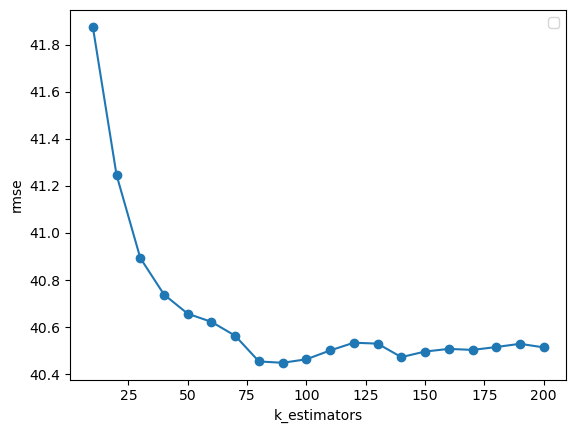

In [51]:
plt.plot(n_estimators, rmse_arr)
plt.scatter(n_estimators, rmse_arr)

plt.xlabel('k_estimators')
plt.ylabel('rmse')
plt.legend()
plt.show()

Let's select the best `max_depth`

In [55]:
max_depth_arr = [10, 15, 20, 25]
n_estimators_arr = np.arange(10, 201, 10)

rmse_arr = np.zeros((len(max_depth_arr), len(n_estimators_arr)))

for i, max_depth in tqdm(enumerate(max_depth_arr)):
    for j, n_estimator in tqdm(enumerate(n_estimators_arr)):
        rf = RandomForestRegressor(
            n_estimators=n_estimator,
            max_depth=max_depth,
            random_state=1
        )
        rf.fit(X_train_full, y_train)

        rmse_arr[i][j] = rmse(
            y_val,
            rf.predict(X_val_full)
        )

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [56]:
rmse_arr.min(axis=1)

array([40.18410132, 40.49738483, 40.54105891, 40.44120569])

Extract feature importance information from tree-based models.

In [57]:
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1
)
rf.fit(X_train_full, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, random_state=1)

In [62]:
features_full[rf.feature_importances_.argmax()]

'study_hours_per_week'

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

In [70]:
dtrain = xgb.DMatrix(X_train_full, label=y_train, feature_names=features_full)
dval = xgb.DMatrix(X_val_full, label=y_val, feature_names=features_full)

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [71]:
model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=100,
    verbose_eval=5,
    evals=watchlist
)

[0]	train-rmse:42.69552	val-rmse:44.82722
[5]	train-rmse:34.43646	val-rmse:40.84320
[10]	train-rmse:31.55119	val-rmse:40.78297
[15]	train-rmse:29.08791	val-rmse:41.30032
[20]	train-rmse:27.24424	val-rmse:41.73318
[25]	train-rmse:25.52682	val-rmse:42.12094
[30]	train-rmse:24.12906	val-rmse:42.24215
[35]	train-rmse:22.40407	val-rmse:42.50176
[40]	train-rmse:21.45994	val-rmse:42.75144
[45]	train-rmse:20.39910	val-rmse:42.92237
[50]	train-rmse:19.30407	val-rmse:43.11197
[55]	train-rmse:18.42737	val-rmse:43.37500
[60]	train-rmse:17.42414	val-rmse:43.40276
[65]	train-rmse:16.59974	val-rmse:43.54433
[70]	train-rmse:15.74173	val-rmse:43.80443
[75]	train-rmse:14.87321	val-rmse:43.93203
[80]	train-rmse:14.28350	val-rmse:44.08736
[85]	train-rmse:13.64009	val-rmse:44.23233
[90]	train-rmse:12.90222	val-rmse:44.31230
[95]	train-rmse:12.05464	val-rmse:44.33670
[99]	train-rmse:11.56417	val-rmse:44.46410


In [74]:
xgb_params_2 = xgb_params.copy()
xgb_params_2['eta'] = 0.1

model_2 = xgb.train(
    xgb_params_2,
    dtrain,
    num_boost_round=100,
    verbose_eval=5,
    evals=watchlist
)

[0]	train-rmse:45.50072	val-rmse:46.98281
[5]	train-rmse:40.15460	val-rmse:43.03879
[10]	train-rmse:37.11353	val-rmse:41.55294
[15]	train-rmse:35.07766	val-rmse:40.69598
[20]	train-rmse:33.57997	val-rmse:40.35824
[25]	train-rmse:32.50134	val-rmse:40.19686
[30]	train-rmse:31.47315	val-rmse:40.17544
[35]	train-rmse:30.68870	val-rmse:40.15682
[40]	train-rmse:29.89807	val-rmse:40.13122
[45]	train-rmse:29.33094	val-rmse:40.17948
[50]	train-rmse:28.58793	val-rmse:40.25777
[55]	train-rmse:27.95277	val-rmse:40.40972
[60]	train-rmse:27.26360	val-rmse:40.51392
[65]	train-rmse:26.56706	val-rmse:40.63147
[70]	train-rmse:26.05959	val-rmse:40.69863
[75]	train-rmse:25.55747	val-rmse:40.71636
[80]	train-rmse:25.13835	val-rmse:40.80460
[85]	train-rmse:24.64140	val-rmse:40.85414
[90]	train-rmse:23.93958	val-rmse:40.87290
[95]	train-rmse:23.39469	val-rmse:40.91659
[99]	train-rmse:23.14487	val-rmse:41.00779
